# Dirty ER - Workflows


In this notebook it's implemented the 3 basic JedAI workflows for Dirty Entity Resolution


## WorkFlow 1



Libraries import

In [1]:
from html import entities
import os
import sys
import pandas as pd
import networkx
from networkx import (
    draw,
    DiGraph,
    Graph,
)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

Import JedAI utilities

In [2]:
from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs

Import of evaluation module

In [3]:
from pyjedai.evaluation import Evaluation

### Data Reading

In [4]:
from pyjedai.datamodel import Data

#### CSV format

In [5]:
d1 = pd.read_csv("./data/cora/cora.csv", sep='|')
gt = pd.read_csv("./data/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']

#### JSON format

In [ ]:
d1 = pd.read_json("./data/cora/cora.json")
gt = pd.read_json("./data/cora/cora_gt.csv")
attr = ['author', 'title']

#### RDF format

In [ ]:
import rdfpandas as rfd
import pandas as pd
import rdflib

g1 = rdflib.Graph()
g1.parse('d1.ttl', format = 'ttl')
g_gt = rdflib.Graph()
g_gt.parse('d1.ttl', format = 'ttl')

d1 = rfd.graph.to_dataframe(g1)
gt = rfd.graph.to_dataframe(g_gt)

#### Relational DB

#### SPARKQL

Data is the connecting module of all steps of the workflow

In [6]:
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

data.process()

### Schema Clustering

In [9]:
# import valentine
# # Instantiate matcher and run
# matcher = Coma(strategy="COMA_OPT")
# matches = valentine_match(df1, df2, matcher)

### Block Building

In [7]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking,
    EmbeddingsNNBlockBuilding
)

In [8]:
blocks = StandardBlocking().build_blocks(data)

Standard Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [12]:
blocks = QGramsBlocking(
    qgrams=2
).build_blocks(data)

Q-Grams Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [13]:
blocks = SuffixArraysBlocking(
    suffix_length=2
).build_blocks(data)

Suffix Arrays Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [14]:
blocks = ExtendedSuffixArraysBlocking(
    suffix_length=2
).build_blocks(data)

Extended Suffix Arrays Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [9]:
Evaluation(data).report(blocks)

#  Evaluation 
---
Scores:
	Precision:      0.64% 
	Recall:        99.99%
	F1-score:       1.27%
Classification report:
	True positives: 17183
	False positives: 2663261
	True negatives: -1825397
	False negatives: 1
	Total comparisons: 2680444
---


#### EmbeddingsNNBlockBuilding

In [13]:
emb = EmbeddingsNNBlockBuilding(
    vectorizer='bert',
    similarity_search='faiss'
)
blocks = emb.build_blocks(data)

Embeddings-NN Block Building:   0%|          | 0/1295 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'shape'

In [14]:
emb.vectors_1

[array([[-3.93110901e-01, -3.49704504e-01, -7.82642961e-02,
         -3.57530475e-01,  2.33119041e-01, -1.82874665e-01,
         -9.67172682e-02, -1.88818663e-01,  2.89864600e-01,
         -3.87977719e-01, -1.43216312e-01,  1.21398583e-01,
         -1.13007772e+00, -2.61934400e-01,  2.52686124e-02,
          8.16418469e-01, -2.20302269e-01,  2.99898237e-01,
         -3.33331585e-01, -3.01957071e-01,  5.07401451e-02,
         -3.25006366e-01,  6.80114508e-01,  2.80584693e-01,
         -6.11410499e-01,  9.50737536e-01,  1.38967447e-02,
         -1.46031439e-01, -2.95367241e-01,  7.08432138e-01,
         -6.17268085e-01,  1.25155821e-02, -3.22245747e-01,
         -2.69146830e-01,  7.95404434e-01,  5.71293831e-01,
         -1.77183390e-01,  2.72394717e-01, -5.30072629e-01,
          5.99119902e-01, -5.23226261e-01,  2.53588229e-01,
         -7.52043352e-03, -8.61056149e-02, -2.61649698e-01,
          6.62930191e-01, -4.04373693e+00,  1.89523976e-02,
         -1.44226015e-01, -6.21434450e-0

In [14]:
Evaluation(data).report(blocks, emb.method_configuration())

# Embeddings-NN Block Building Evaluation 
---
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: fasttext
	Similarity-Search: faiss
	Top-K: 100
	Vector size: 300
Runtime: 404.8856 seconds
Scores:
	Precision:      8.85% 
	Recall:        66.00%
	F1-score:      15.60%
Classification report:
	True positives: 11341
	False positives: 116864
	True negatives: 715158
	False negatives: 5843
	Total comparisons: 128205
---


### Block Cleaning

In [16]:
from pyjedai.block_cleaning import (
    BlockFiltering
)

In [17]:
filtered_blocks = BlockFiltering(
    ratio=0.9
).process(blocks, data)

Block Filtering:   0%|                                                                           | 0/3 [00:00<…

In [18]:
Evaluation(data).report(filtered_blocks)

#  Evaluation 
---
Scores:
	Precision:      2.09% 
	Recall:        46.45%
	F1-score:       4.00%
Classification report:
	True positives: 7982
	False positives: 374210
	True negatives: 454453
	False negatives: 9202
	Total comparisons: 382192
---


### Comparison Cleaning - Meta Blocking

In [19]:
from pyjedai.block_cleaning import (
    BlockPurging
)

In [20]:
cleaned_blocks = BlockPurging(
    smoothing_factor=0.008
).process(blocks, data)

Block Purging:   0%|          | 0/8088 [00:00<?, ?it/s]

In [21]:
Evaluation(data).report(cleaned_blocks)

#  Evaluation 
---
Scores:
	Precision:      2.65% 
	Recall:         0.52%
	F1-score:       0.87%
Classification report:
	True positives: 89
	False positives: 3272
	True negatives: 817498
	False negatives: 17095
	Total comparisons: 3361
---


In [22]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    # ReciprocalCardinalityWeightPruning,
    ComparisonPropagation
)

In [23]:
candidate_pairs_blocks = WeightedEdgePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data)

Weighted Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [24]:
candidate_pairs_blocks = WeightedNodePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Weighted Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [25]:
candidate_pairs_blocks = CardinalityEdgePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Cardinality Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [26]:
candidate_pairs_blocks = CardinalityNodePruning(
    weighting_scheme='JS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Cardinality Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [27]:
candidate_pairs_blocks = BLAST(
    weighting_scheme='JS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

BLAST:   0%|          | 0/1295 [00:00<?, ?it/s]

In [28]:
candidate_pairs_blocks = ReciprocalCardinalityNodePruning(
    weighting_scheme='JS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Reciprocal Cardinality Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [29]:
candidate_pairs_blocks = ComparisonPropagation().process(blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Comparison Propagation:   0%|          | 0/1295 [00:00<?, ?it/s]

In [30]:
Evaluation(data).report(candidate_pairs_blocks)

#  Evaluation 
---
Scores:
	Precision:     14.80% 
	Recall:        48.14%
	F1-score:      22.64%
Classification report:
	True positives: 8273
	False positives: 47632
	True negatives: 781322
	False negatives: 8911
	Total comparisons: 55905
---


### Entity Matching

In [31]:
from pyjedai.matching import EntityMatching

In [32]:
attr = ['author', 'title']
# or with weights
attr = {
    'author' : 0.6,
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
    # embedings=None, # gensim
    # attributes=attr,
    # qgram=2 # for ngram metric or jaccard
)

# pairs_graph = EM.predict(blocks, data)

In [33]:
pairs_graph = EM.predict(filtered_blocks, data)

Entity Matching (jaccard):   0%|          | 0/3986 [00:00<?, ?it/s]

In [34]:
attr = {
    'author' : 0.6, 
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
    # embedings=None, # gensim
    # attributes=attr,
    # qgram=2 # for ngram metric or jaccard
)

pairs_graph = EM.predict(candidate_pairs_blocks, data)

Entity Matching (jaccard):   0%|          | 0/1294 [00:00<?, ?it/s]

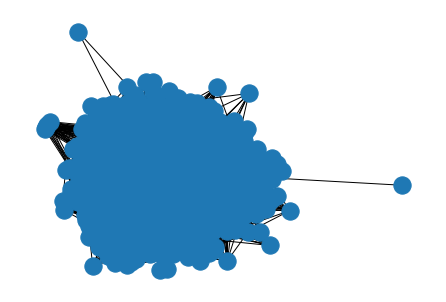

In [35]:
draw(pairs_graph)

In [36]:
e = Evaluation(data)
e.report(pairs_graph)

#  Evaluation 
---
Scores:
	Precision:      1.74% 
	Recall:         4.71%
	F1-score:       2.54%
Classification report:
	True positives: 810
	False positives: 45749
	True negatives: 775742
	False negatives: 16374
	Total comparisons: 46559
---


### Entity Clustering

In [37]:
from pyjedai.clustering import ConnectedComponentsClustering

In [38]:
clusters = ConnectedComponentsClustering().process(pairs_graph)

In [39]:
e = Evaluation(data)
e.report(pairs_graph)

#  Evaluation 
---
Scores:
	Precision:      1.74% 
	Recall:         4.71%
	F1-score:       2.54%
Classification report:
	True positives: 810
	False positives: 45749
	True negatives: 775742
	False negatives: 16374
	Total comparisons: 46559
---


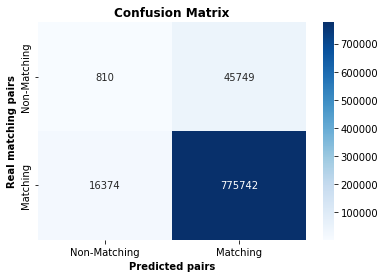

In [40]:
e.confusion_matrix()

## WorkFlow 2



### Data Reading

Data is the connecting module of all steps of the workflow

In [41]:
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/cora/cora.csv", sep='|')
gt = pd.read_csv("./data/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

data.process()

### Similarity Joins

In [42]:
from pyjedai.joins import SchemaAgnosticΕJoin, TopKSchemaAgnosticJoin

In [43]:
g = SchemaAgnosticΕJoin(
    threshold = 0.5,
    metric = 'jaccard',
    tokenization = 'qgrams_multiset',
    qgrams = 2
).fit(data)

Schema Agnostic Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

In [44]:
e = Evaluation(data)
e.report(g)

#  Evaluation 
---
Scores:
	Precision:     65.80% 
	Recall:        93.03%
	F1-score:      77.08%
Classification report:
	True positives: 15987
	False positives: 8311
	True negatives: 828357
	False negatives: 1197
	Total comparisons: 24298
---


In [45]:
g = TopKSchemaAgnosticJoin(
    K=20,
    metric = 'jaccard',
    tokenization = 'qgrams',
    qgrams = 3
).fit(data)

Top-K Schema Agnostic Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

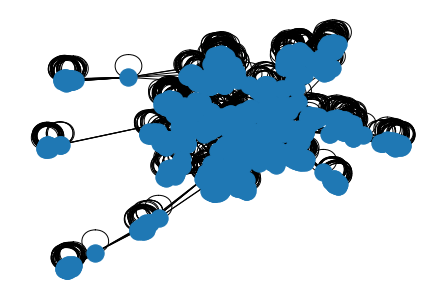

In [46]:
draw(g)

In [47]:
e = Evaluation(data)
e.report(g)

#  Evaluation 
---
Scores:
	Precision:     58.34% 
	Recall:        63.75%
	F1-score:      60.92%
Classification report:
	True positives: 10954
	False positives: 7822
	True negatives: 823813
	False negatives: 6230
	Total comparisons: 18776
---


### Entity Clustering

In [48]:
from pyjedai.clustering import ConnectedComponentsClustering

In [49]:
clusters = ConnectedComponentsClustering().process(g)

In [50]:
e = Evaluation(data)
e.report(clusters)

#  Evaluation 
---
Scores:
	Precision:      2.05% 
	Recall:       100.00%
	F1-score:       4.02%
Classification report:
	True positives: 17184
	False positives: 820681
	True negatives: 17184
	False negatives: 0
	Total comparisons: 837865
---


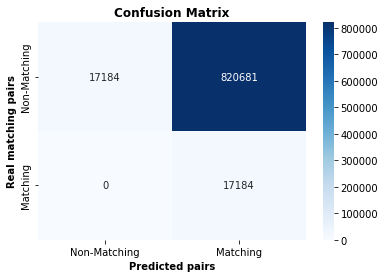

In [51]:
e.confusion_matrix()

## WorkFlow 3

